In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv
/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv
/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv


In [17]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset

In [9]:
def get_logger(filename=paths.OUTPUT_DIR):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

In [8]:
class config:
    FOLDS = 5
    MODEL = "microsoft/deberta-v3-base"
    MAX_LEN = 512
    
class paths:
    OUTPUT_DIR = "/kaggle/working/output"

In [10]:
train_df = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv')
train_df['score'] = train_df['score'].map(lambda x: x-1)
test_df = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv')
print(train_df.shape)
print(test_df.shape)

(17307, 3)
(3, 2)


In [11]:
display(train_df),display(test_df)

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,2
1,000fe60,I am a scientist at NASA that is discussing th...,2
2,001ab80,People always wish they had the same technolog...,3
3,001bdc0,"We all heard about Venus, the planet without a...",3
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",2
...,...,...,...
17302,ffd378d,"the story "" The Challenge of Exploing Venus "" ...",1
17303,ffddf1f,Technology has changed a lot of ways that we l...,3
17304,fff016d,If you don't like sitting around all day than ...,1
17305,fffb49b,"In ""The Challenge of Exporing Venus,"" the auth...",0


,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...


(None, None)

In [12]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
train_df['fold'] = -1
X = train_df['full_text']
y = train_df['score']

skf = StratifiedKFold(n_splits=config.FOLDS)

for i,(train_index,val_index) in enumerate(skf.split(X,y)):
    train_df.loc[val_index,'fold'] = i
    
print(train_df['fold'].value_counts())

fold
0    3462
1    3462
2    3461
3    3461
4    3461
Name: count, dtype: int64


In [13]:
tokenizer = AutoTokenizer.from_pretrained(config.MODEL)
tokenizer.save_pretrained(paths.OUTPUT_DIR + '/tokenizer/')
print(tokenizer)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


DebertaV2TokenizerFast(name_or_path='microsoft/deberta-v3-base', vocab_size=128000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	128000: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


max_len: 512


(array([5.394e+03, 6.238e+03, 3.732e+03, 1.316e+03, 4.460e+02, 1.290e+02,
        2.800e+01, 1.500e+01, 8.000e+00, 1.000e+00]),
 array([ 160. ,  321.6,  483.2,  644.8,  806.4,  968. , 1129.6, 1291.2,
        1452.8, 1614.4, 1776. ]),
 <BarContainer object of 10 artists>)

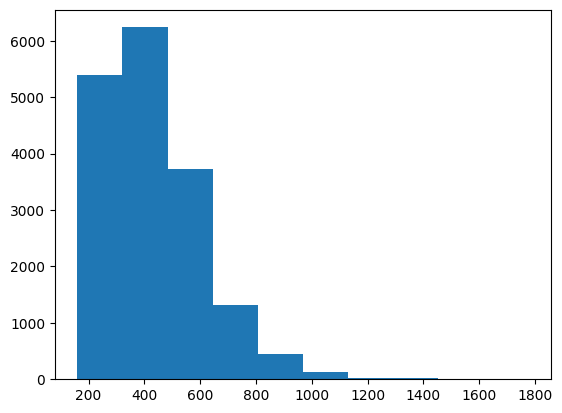

In [15]:
lengths = []
tqdm_loader = train_df['full_text']
for text in tqdm_loader:
    length = len(tokenizer(text,add_special_tokens=False)['input_ids'])
    lengths.append(length)

LOGGER.info(f'max_len: {config.MAX_LEN}')
plt.hist(lengths)

In [16]:
train_df.head()

,essay_id,full_text,score,fold
0,000d118,Many people have car where they live. The thin...,2,0
1,000fe60,I am a scientist at NASA that is discussing th...,2,0
2,001ab80,People always wish they had the same technolog...,3,0
3,001bdc0,"We all heard about Venus, the planet without a...",3,0
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",2,0


In [19]:
def prepare_input(cfg,text,tokenizer):
    '''
    tokenizer.enocde.plus returns a dictionary containing information about the encoded sequence.
    -> input_ids = A list of integer IDs corresponsing to the tokens in the sequence.
             
    -> attention_mask = binary mask indicating which tokens are valid(1) and which are paddings(0).
             This helps the model to focus on the actual content and ignore the padding.
    
    -> token_type_ids = (optional): In some cases, this might be used to distinguish between 
    different parts of the input (e.g., question and answer in a question-answering task).
    '''
    inputs = tokenizer.encode.plus(
        text,
        return_tensors=None,
        add_special_tokens = True,
        max_length = cfg.MAX_LEN,
        padding = 'max_len',
        truncation = True
    )
    
    for k,v in inputs.items():
        inputs[k] = torch.tensor(v,dtype=torch.long)
    return inputs

def collate(inputs):
    """
    It truncates the inputs to the maximum of the sequence length in the batch.
    """
    mask_len = int(inputs['attention_mask'].sum(axis=1).max()) #maximum sequence length for the batch
    for k,v in inputs.items():
        inputs[k] = inputs[k][:,:mask_len]
    
    return inputs

class CustomDataset(Dataset):
    def __init__(self,cfg,df,tokenizer):
        self.cfg = cfg
        self.texts = df['full_text']
        self.tokenizer = tokenizer
        self.labels = df['score'].values
        self.essay_ids = df['essay_ids'].values
        
    def __len__(self):
        return len(self.texts)
            
    def __getitem__(self,item):
        output = {}
        output["inputs"] = prepare_input(self.cfg, self.texts[item], self.tokenizer)
        output["labels"] = torch.tensor(self.labels[item], dtype=torch.long) # TODO: check dtypes
        output["essay_ids"] = self.essay_ids[item]
        return output

## Model